# Initialization

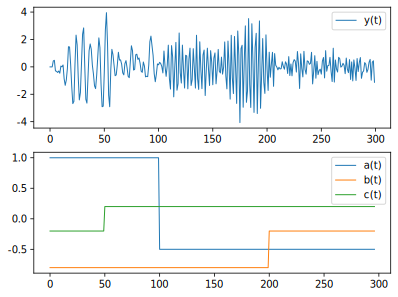

In [1]:
from scipy import io
import numpy as np
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
import matplotlib as mpl
mpl.rcParams["axes.unicode_minus"] = False

import pyomo.environ as pyo
import pprint
pp = pprint.PrettyPrinter(indent=4)

cd_data = io.loadmat('change_detection.mat')

cd_y = cd_data["y"].flatten()

plt.subplot(211)
plt.plot(cd_y, label = "y(t)", linewidth = 1)
plt.legend()
plt.subplot(212)
plt.plot(cd_data["a"].flatten(), label = "a(t)", linewidth = 1)
plt.plot(cd_data["b"].flatten(), label = "b(t)", linewidth = 1)
plt.plot(cd_data["c"].flatten(), label = "c(t)", linewidth = 1)
plt.legend()
plt.show()

In [3]:
print(cd_data["a"][0], cd_data["a"][-1])
print(cd_data["b"][0], cd_data["b"][-1])
print(cd_data["c"][0], cd_data["c"][-1])

[1.] [-0.5]
[-0.8] [-0.2]
[-0.2] [0.2]


# Greedy regression

## model
Considering a, b, and c steady for a given size of the input data, compute a regression on a reduced input set.

The problem to solve is :

$$ \min_{a, b, c} \sum_{i} f(y_{i+3} - a y_{i+2} - b y_{i+1} - c y_{i}) $$

Two options are implemented for f :
- 1: corresponds to $N1$ : $f(x) = |x|$
- 2: corresponds to the square of $N2$: $f(x) = x^2.

To implement $N1$, considering the available solvers can only solve linear or quadratic objective functions, the absolute value is transformed into a linear program by having: $x = t^+ - t^-$ with $\{t^+,t^-\} \in \mathbb{R}_{+}^2$. Therefore by minimizing $t^+ + t^-$, one of $t^+$ or $t^-$ will be set to $0$, and the other $|x|$.

In [4]:
def regression(y, sample_size, norm = 1):
    model = pyo.AbstractModel()
    model.data_index_set = pyo.RangeSet(sample_size)
    model.y = pyo.Param(model.data_index_set, initialize = lambda _, i: y[i - 1])

    model.var_index_set = model.data_index_set - {sample_size, sample_size - 1, sample_size - 2}
    model.a = pyo.Var()
    model.b = pyo.Var()
    model.c = pyo.Var()

    def rec_expr(_, i):
        return  model.y[i + 3] \
                - model.a * model.y[i + 2] \
                - model.b * model.y[i + 1] \
                - model.c * model.y[i]
    fun_obj = None
    if norm == 1:
        model.t1  = pyo.Var(model.var_index_set, domain = pyo.NonNegativeReals)
        model.t2  = pyo.Var(model.var_index_set, domain = pyo.NonNegativeReals)
        model.to_abs = pyo.Var(model.var_index_set)
        model.const_init_abs = pyo.Constraint(model.var_index_set, rule = lambda m,i: m.to_abs[i] == rec_expr(m,i))
        model.const_abs = pyo.Constraint(model.var_index_set, rule = lambda m,i: m.to_abs[i] == m.t1[i] - m.t2[i])
        fun_obj = lambda m: sum(m.t1[i] + m.t2[i] for i in m.var_index_set)

    else:
        fun_obj = lambda m: sum(rec_expr(m, i)**2 for i in m.var_index_set)

    model.obj = pyo.Objective(rule = fun_obj)

    model.construct()
    
    solver = pyo.SolverFactory("ipopt")
    report = solver.solve(model)
    return model, report

a: 1.168, b: -0.988, c: 0.017


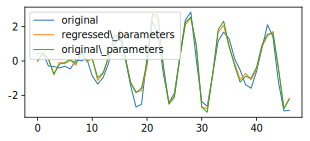

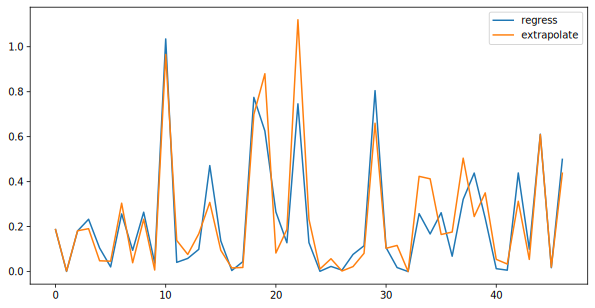

sum_regress = 10.523	 sum_orig = 11.076


In [5]:
sample_size = 50
display_size = 50

model1, _ = regression(cd_y, sample_size, 1)
model2, _ = regression(cd_y, sample_size, 2)
def my_sub_plot(cd_y, model, column):
    lw = 1
    y = [model.a.value * cd_y[i + 2] + model.b.value * cd_y[i + 1] + model.c.value * cd_y[i] for i in range(display_size)]
    plt.subplot(3, 2, column)
    plt.title(str(column))
    plt.plot(y, color = 'blue', linewidth = lw, label = 'prev')
    plt.plot(cd_data["y"][3:display_size + 3], color = 'red', linewidth = lw, label = 'real')
    plt.legend()
    plt.subplot(3, 2, column + 2)
    plt.plot([abs(y[i] - cd_data['y'][i + 3]) for i in range(display_size)], linewidth = lw, label = 'diff')
    plt.legend()
    return y

# y1 = my_sub_plot(cd_y, model1, 1)
# y2 = my_sub_plot(cd_y, model2, 2)
# plt.subplot(3,2,5)
# plt.plot(y1, y2, '.', label = 'prev2 = f(prev1)')
# plt.legend()
# plt.show()
print(f"a: {model2.a.value:.3f}, b: {model2.b.value:.3f}, c: {model2.c.value:.3f}")
def extrapolate(y,param,size):
    return [param[0] * y[i + 2] + param[1] * y[i + 1] + param[2] * y[i] for i in range(size-3)]

param_regress = (model2.a.value, model2.b.value,model2.c.value)
param_orig = (1, -.8, -.2)
y_regress = extrapolate(cd_y, param_regress, sample_size)
y_extrapolate = extrapolate(cd_y, param_orig, sample_size)

plt.figure(figsize=(5,2))
plt.plot(cd_y[3:sample_size], linewidth = 1, label = 'original')
plt.plot(y_regress, linewidth = 1, label = 'regressed\\_parameters')
plt.plot(y_extrapolate, linewidth = 1, label = 'original\\_parameters')
plt.legend()
plt.show()

def sq_diff (x, y):
    return [(y[i+3]-x[i])**2 for i in range(len(x))]

y_regress_sq_diff = sq_diff(y_regress, cd_y)
y_extrapolate_sq_diff = sq_diff(y_extrapolate, cd_y)
plt.figure(figsize=(10,5))
plt.plot(y_regress_sq_diff, label = "regress")
plt.plot(y_extrapolate_sq_diff, label = "extrapolate")
plt.legend()
plt.show()

print(f"sum_regress = {sum(y_regress_sq_diff):.3f}\t sum_orig = {sum(y_extrapolate_sq_diff):.3f}")



# Change detection with off-the-shelf solver

## time detection

In [6]:
def change_detection(cd_y, sample_size, mu):
    model = pyo.AbstractModel()
    model.data_index_set = pyo.RangeSet(0, sample_size - 1)
    model.y = pyo.Param(model.data_index_set, initialize = lambda _, i: cd_y[i])

    model.var_index_set = model.data_index_set - {sample_size - 1, sample_size - 2, sample_size - 3}
    model.var_dim_set = pyo.RangeSet(0, 2)
    
    model.w = pyo.Var(model.var_dim_set, model.var_index_set)

    model.var_d_set = model.var_index_set - {sample_size - 4}
    model.d_abs = pyo.Var(model.var_dim_set, model.var_d_set, {1 , 2}, domain = pyo.NonNegativeReals)
    
    model.contr_d = pyo.Constraint(model.var_dim_set, model.var_d_set,
                                   rule = lambda m, i, j: m.d_abs[i, j, 2] - m.d_abs[i, j, 1]  == m.w[i, j + 1] - m.w[i, j])

    def rec_expr(m, i):
        return  m.y[i + 3] \
                - m.w[0, i] * m.y[i + 2] \
                - m.w[1, i] * m.y[i + 1] \
                - m.w[2, i] * m.y[i]

    def obj_expr(m) :
        return sum(rec_expr(m, i)**2 for i in m.var_index_set) + mu * pyo.summation(m.d_abs)
        # return sum(rec_expr(m, i)**2 for i in m.var_index_set) \
        #     + sum(mu[i] * m.d_abs[i, j, k] for i in m.var_dim_set for j in m.var_d_set for k in {1, 2})

    model.obj = pyo.Objective(rule = obj_expr)

    model.construct()

    solver = pyo.SolverFactory("ipopt")
    report = solver.solve(model, logfile = 'log.txt')
    return model, report


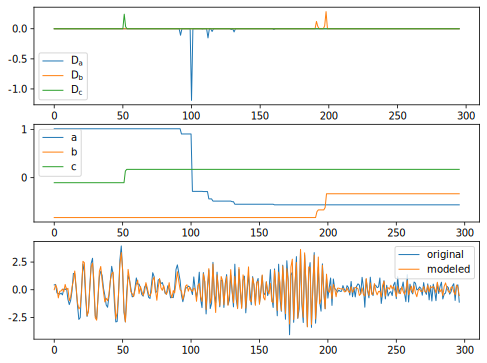


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 888
  Number of variables: 2667
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.14.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.07984685897827148
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [23]:
sample_size = 300
mu = 10
model, report = change_detection(cd_y, sample_size, mu)

label = ['a', 'b', 'c']
display_size = sample_size - 3
lw = 1
plt.figure(figsize=(8,6))
plt.subplot(311)
for i in range(3):
    plt.plot([model.d_abs[i, j, 2].value - model.d_abs[i, j, 1].value for j in range(display_size-1)], linewidth = lw, label = f"$D_{label[i]}$")
plt.legend()
plt.subplot(312)
for i in range(3):
    plt.plot([model.w[i, j].value for j in range(display_size)], linewidth = lw, label = label[i])
plt.legend()

y = [model.w[0, i].value * cd_y[i + 2] + model.w[1, i].value * cd_y[i + 1] + model.w[2, i].value * cd_y[i] for i in range(display_size)]
plt.subplot(313)
plt.plot(cd_y[3:], linewidth = lw, label = 'original')
plt.plot(y, linewidth = lw, label = 'modeled')
plt.legend()
plt.show()
print(report)

## Final regression

In [14]:
def identify_change_index(model):
    res = []
    for dim in {0, 1, 2}:
        list = [model.d_abs[dim, i, 2].value + model.d_abs[dim, i, 1].value for i in model.var_d_set]
        res.append(list.index(max(list)))
    return tuple(res)

def final_regression(cd_y, sample_size: int, change_indexes: tuple[int, int, int]):
    model = pyo.AbstractModel()
    model.data_index_set = pyo.RangeSet(0, sample_size - 1)
    model.y = pyo.Param(model.data_index_set, initialize = lambda _, i: cd_y[i])

    model.var_index_set = model.data_index_set - {sample_size - 1, sample_size - 2, sample_size - 3}
    model.var_dim_set = pyo.RangeSet(0, 2)
    
    model.w = pyo.Var(model.var_dim_set, {0, 1})

    def rec_expr(m, i):
        return  m.y[i + 3] \
                - (m.w[0, 0] if i<=change_indexes[0] else m.w[0,1]) * m.y[i + 2] \
                - (m.w[1, 0] if i<=change_indexes[1] else m.w[1,1]) * m.y[i + 1] \
                - (m.w[2, 0] if i<=change_indexes[2] else m.w[2,1]) * m.y[i]

    def obj_expr(m) :
        return sum(rec_expr(m, i)**2 for i in m.var_index_set)

    model.obj = pyo.Objective(rule = obj_expr)

    model.construct()

    solver = pyo.SolverFactory("ipopt")
    report = solver.solve(model, logfile = 'log.txt')
    return model, report

In [15]:
ci_predict = identify_change_index(model)
print(f" detected indexes change of (a,b,c): {ci_predict}")
fm, fr = final_regression(cd_y, sample_size, ci_predict)
fm.pprint()
print(report)

 detected indexes change of (a,b,c): (100, 198, 51)
4 Set Declarations
    var_index_set : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain                                 : Size : Members
        None :     1 : data_index_set - var_index_set_index_0 :  297 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 

In [20]:
def plot_result(cd_y, p, change_index, column, title):
    p_ts = [[p[d][0] if j<change_index[d] else p[d][1] for j in range(sample_size - 3)] for d in range(3)]
    y_prev = [p_ts[0][i] * cd_y[i + 2] + p_ts[1][i] * cd_y[i + 1] + p_ts[2][i] * cd_y[i] for i in range(sample_size - 3)]
    diff = y_prev-cd_y[3:]
    plt.subplot(4, 2, column)
    plt.title(f"{title}: mean :${np.mean(diff):.2e}$, std: ${np.std(diff):.2e}$")
    for dim in range(3):
        plt.plot(p_ts[dim], label = f"${label[dim]}$")
    plt.legend()
    plt.subplot(4, 2, column + 2)
    plt.plot(y_prev, linewidth = lw, label = "$original$")
    plt.plot(cd_y[3:], linewidth = lw, label = "$extrapolate$")
    plt.legend()
    plt.subplot(4, 2, column + 4)
    plt.plot(diff, linewidth = lw, label = "$extrapolate - original$")
    plt.legend()
    plt.subplot(4, 2, column + 6)
    plt.hist(diff, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
    

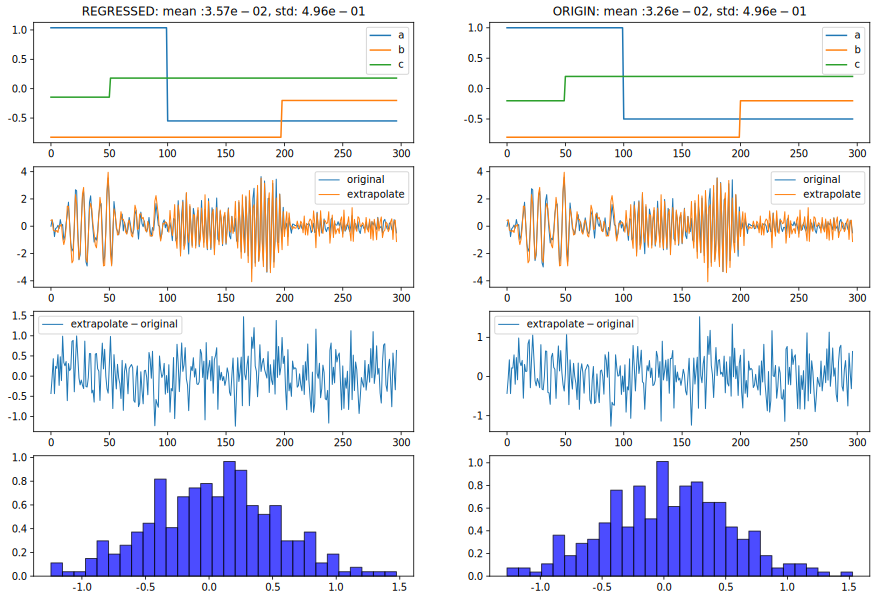

In [22]:
plt.figure(figsize=(15,10))

p_predict = [[fm.w[d,0].value, fm.w[d,1].value] for d in fm.var_dim_set]
plot_result(cd_y, p_predict, ci_predict, 1, "REGRESSED")

p_orig = [[1, -.5], [-.8, -.2], [-.2, .2]]
ci_orig = (100, 200, 50)
plot_result(cd_y, p_orig, ci_orig, 2, "ORIGIN")

plt.show()

In [471]:
for dim in range(3): print(f"{fm.w[dim, 0].value:.2f} | {fm.w[dim, 1].value:.2f}")

1.04 | -0.55
-0.83 | -0.20
-0.14 | 0.18



|   | 1 | 2 |
|:---:|:---:|:---:|
| a | 1.04 | -0.55 |
| b | -0.83 | -0.20 |
| c | -0.14 | 0.16 |

|   | 1 | 2 |
|:---:|:---:|:---:|
| a | 1 | -0.5 |
| b | -0.8 | -0.2 |
| c | -0.2 | 0.2 |



# Low complexity algorithm

## Gradient descent

In [472]:
def gradient_descent(fun, d_fun, x0, epsilon, alpha = 0.1, beta=0.7, i_max = 10, backtracking_max = 10):
    
    def backtracking_line_search(fun, x, delta_x, d_f_x, alpha, beta, bt_max = 10):
        t = 1
        i = 1
        f_x = fun(x)
        delta_times_d_f = np.dot(d_f_x, delta_x)
        while(fun(np.add(x, t * delta_x)) > f_x + alpha * t * delta_times_d_f and i <= bt_max):
            t = beta * t
            i += 1
        return i, x + t * delta_x
    
    x = x0
    i = 0
    term_bt = 0
    while(np.linalg.norm(d_fun(x)) > epsilon and i <= i_max and term_bt < backtracking_max):
        d_f_x = d_fun(x)
        delta_x = np.multiply(d_f_x, -1)
        term_bt, x = backtracking_line_search(fun, x, delta_x, d_f_x, alpha, beta, backtracking_max)
        print(f"i: {i}\tterm_bt: {term_bt}\tx: {x}\tf_x: {fun(x)}")
        i += 1
    return term_bt, i, x, fun(x), d_fun(x)

# fun = lambda x: x[0]**2 + 2*x[0]
# d_fun = lambda x: 2*x[0] + 2
fun = lambda x: (x[0] + 2) ** 2 + (x[1] - 3) ** 2
d_fun = lambda x: (2 * (x[0] + 2), 2 * (x[1] - 3))
# fun = lambda x: abs(x[0] + 2) + abs(x[1] - 3)
# d_fun = lambda x: (1 if x[0] >= -2 else -1, 1 if x[1] >= 3 else -1)

term_bt, i, x, f_x, d_f_x = gradient_descent(fun, d_fun, [5,7], 0.001, alpha = 0.3, beta = 0.6, i_max = 100, backtracking_max = 100)

print(f"term_bt: {term_bt}\ti: {i}\tx: {x}\tf_x: {f_x}\td_f_x: {d_f_x}")

i: 0	term_bt: 2	x: [-3.4  2.2]	f_x: 2.6000000000000005
i: 1	term_bt: 2	x: [-1.72  3.16]	f_x: 0.10400000000000006
i: 2	term_bt: 2	x: [-2.056  2.968]	f_x: 0.0041600000000000074
i: 3	term_bt: 2	x: [-1.9888  3.0064]	f_x: 0.00016640000000000456
i: 4	term_bt: 2	x: [-2.00224  2.99872]	f_x: 6.6559999999999546e-06
i: 5	term_bt: 2	x: [-1.999552  3.000256]	f_x: 2.662399999999073e-07
i: 6	term_bt: 2	x: [-2.0000896  2.9999488]	f_x: 1.0649599999998565e-08
term_bt: 2	i: 7	x: [-2.0000896  2.9999488]	f_x: 1.0649599999998565e-08	d_f_x: (-0.00017919999999982394, -0.00010240000000028004)


## Basic subgradient method

In [590]:
def subgradient_method(fun_and_grad, x_0, alpha, min_k, max_k):
    f_x, _, _ = fun_and_grad(x_0)
    f_k = [f_x]
    f_min = f_x
    k_min = 0
    x = x_0
    x_min = np.copy(x_0)
    k = 0
    log_time_series = []
    while(k <= max_k):
        f_x, d_f_x, log = fun_and_grad(x)
        if f_x<f_min or k == min_k:
            f_min = f_x
            k_min = k
            x_min = np.copy(x)
        log_time_series.append(log)
        delta_x = np.multiply(d_f_x, -alpha(k, d_f_x))
        x = np.add(x, delta_x)
        f_k.append(f_x)
        k += 1
    return f_min, x_min, k_min, f_k, log_time_series

2.7977620220553945e-14 [-2.  3.] 982


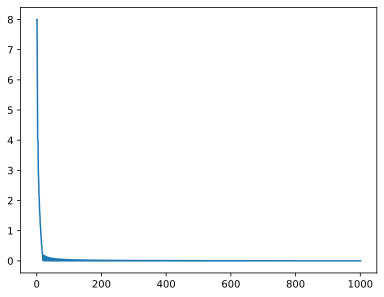

In [591]:
fun = lambda x: abs(x[0] + 2) + abs(x[1] - 3)
d_fun = lambda x: (1 if x[0] >= -2 else -1, 1 if x[1] >= 3 else -1)
fun_and_grad = lambda x: (fun(x), d_fun(x), None)

alpha_const = lambda alpha: (lambda k, df: alpha)                                   #0.01          
alpha_constant_step_lenght = lambda gamma: (lambda k, df: gamma/np.linalg.norm(df)) # 0.1
alpha_sq_summable = lambda a, b: (lambda k, df: a / (b+k))                          #(2,1)
alpha_nonsummable_diminishing = lambda a: lambda k,df : a/np.sqrt(k+1)              #1
alpha_nonsummable_diminishing_step_length = lambda gamma : lambda k, df : gamma/np.linalg.norm(df)/np.sqrt(k+1) #1

f_min, x_min, k_min, f_k, _ = subgradient_method(fun_and_grad, [5,2], alpha_sq_summable(2,1), 0, 1000)
print(f_min, x_min, k_min)
plt.plot([f_k[i] for i in range(len(f_k))])
plt.show()


## Time detection

In [1162]:
def abs_error(y, x, sample_size, i):
    size = sample_size - 3
    f = y[i + 3] \
            - x[i] * y[i + 2]\
            - x[size + i] * y[i + 1]\
            - x[size * 2 + i] * y[i]
    subgrads_f = [(i, -y[i + 2]),
                  (size + i, -y[i + 1]),
                  (size * 2 + i, -y[i])] if f > 0\
            else [(i,  y[i + 2]),
                  (size + i,  y[i + 1]),
                  (size * 2 + i,  y[i])]
    return abs(f), subgrads_f

def sqr_error(y, x, sample_size, i, no_grad=False):
    size = sample_size - 3
    f = y[i + 3] \
            - x[i] * y[i + 2]\
            - x[size + i] * y[i + 1]\
            - x[size * 2 + i] * y[i]
    subgrads_f = [] if no_grad else [(i, -2 * y[i + 2] * f),
                  (size + i, -2 * y[i + 1] * f),
                  (size * 2 + i, -2 * y[i] * f)]
    return f*f, subgrads_f

def d_log_error(x, sample_size, i, mu):
    size = sample_size - 3
    f = 0
    subgrads_f = []
    for k in range(3):
        a = mu * (x[k * size + i + 1] - x[k * size + i])
        f += abs(a)
        if abs(a)>1e-3:
            subgrads_f.append((k * size + i + 1, mu if a > 0 else -mu))
            subgrads_f.append((k * size + i,    -mu if a > 0 else  mu))    
        else:
            nu = 1e1
            # f += np.log(np.cosh(nu * a)) / nu
            grad = np.tanh(nu * a)
            subgrads_f.append((k * size + i + 1, grad))
            subgrads_f.append((k * size + i,     -grad))
    return f, subgrads_f

def d_abs_error(x, sample_size, i, mu):
    size = sample_size - 3
    f = 0
    subgrads_f = []
    for k in range(3):
        a = mu * (x[k * size + i + 1] - x[k * size + i])
        abs_a = abs(a)
        f += abs_a
        flat_grad = 0
        if abs_a/mu < flat_grad:
            subgrads_f.append((k * size + i + 1, 0))
            subgrads_f.append((k * size + i,     0))
        else:
            subgrads_f.append((k * size + i + 1, mu if a > 0 else -mu))
            subgrads_f.append((k * size + i,    -mu if a > 0 else  mu))
    return f, subgrads_f

def objective_and_grad(y, x, sample_size, mu):
    res = 0
    subgrads = []
    err_sum, d_err_sum = 0,0
    for i in range(sample_size - 4):
        f_err, subgrads_err = sqr_error(y, x, sample_size, i)
        f_d_error, subgrads_d_err = d_abs_error(x, sample_size, i, mu)
        res += f_err + f_d_error
        err_sum += f_err
        d_err_sum += f_d_error
        subgrads += subgrads_err
        subgrads += subgrads_d_err
    
    i = sample_size - 4
    f_err, subgrads_err = sqr_error(y, x, sample_size, i)
    res += f_err
    err_sum += f_err
    subgrads += subgrads_err

    res_subgrads = np.zeros((sample_size - 3) * 3)
    for sg in subgrads:
        res_subgrads[sg[0]] += sg[1]
    
    return res, res_subgrads, [err_sum, d_err_sum]
    

def run_and_plot(cd_y, sample_size, mu, x0, alpha, min_k, max_k):
    fun_and_grad = lambda y, sample_size, mu: lambda x: objective_and_grad(y, x, sample_size, mu)
    f_min, x_min, k_min, f_k, log = subgradient_method(fun_and_grad(cd_y, sample_size, mu), x0, alpha, min_k, max_k)
    print(f_min, k_min)
    
    err = [l[0] for l in log]
    d_err = [l[1] for l in log]
    plt.figure(figsize=(20,10))
    plt.subplot(231)
    plt.plot(f_k, label = 'total error')
    plt.legend()
    plt.subplot(232)
    plt.plot(err, label = "err")
    plt.legend()
    plt.subplot(233)
    plt.plot(d_err, label = "d_err")
    plt.legend()
    plt.subplot(234)
    for i in range(3):
        plt.plot(x_min[(sample_size - 3) * i:(sample_size - 3) * (i+1) -1], label = label[i])
    plt.legend()
    plt.subplot(235)
    for i in range(3):
        plt.plot([x_min[(sample_size - 3) * i + j + 1] - x_min[(sample_size - 3) * i + j]  for j in range(sample_size-4)], label = label[i])

    plt.legend()
    plt.show()
    return f_min, x_min, k_min, f_k, log


0.0
212.4098690691816 983


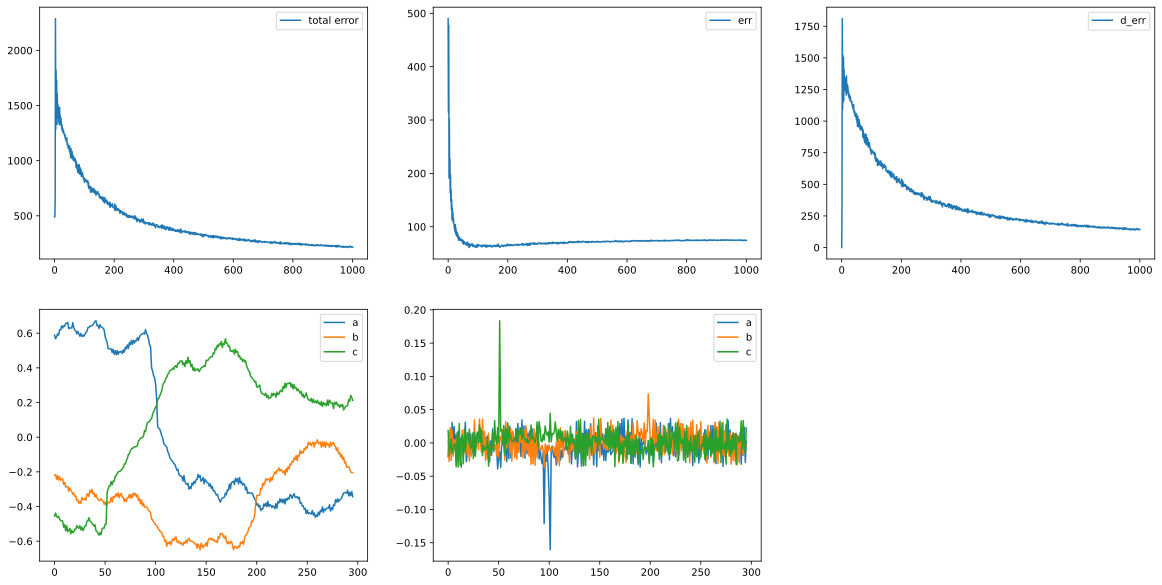

[74.86900215431801, 137.54086691486364] 13.754086691486364


In [1168]:
sample_size = 300
x_0 = np.zeros((sample_size - 3) * 3)
init = [1, -.8, -.2]
# for i,k in enumerate(init):
#     for j in range(sample_size -3):
#         x[i * (sample_size-3) + j] = k
# k += 1
# k=12
# print(k)
mu = 10
# alpha = alpha_nonsummable_diminishing(0.001)
step = 1e3
# k+=1
k = 0
print(k*step)
# alpha = alpha_const(1e-3))
alpha = alpha_sq_summable(1, 100)
# alpha = alpha_nonsummable_diminishing_step_length(1e1)
# alpha = alpha_nonsummable_diminishing(1e-2)
# alpha = lambda k, df : 1e2/((2e2 + k)**2)
max_k = 1e3
min_k = 50
f_min, x_min, k_min, f_k, log = run_and_plot(cd_y, sample_size, mu, np.copy(x_0), alpha, min_k, max_k)
print(log[k_min], log[k_min][1]/mu)

In [952]:
x_res = [[x_min[k * (sample_size - 3) + i] for i in range(sample_size - 3)] for k in range(3)]
d_x_res = [[x_res[k][i + 1] - x_res[k][i] for i in range(sample_size - 4)] for k in range(3)]
pp.pprint(d_x_res[1])
# plt.plot(d_x_res[0])

[   0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    -0.01007357386695834,
    0.0,
    -0.01895508582987243,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    -0.010108916750832198,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    -0.012358855237480815,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    -0.013199831420765862,
    0.0,
    0.0,
    0.0,
    0.0,
    0.011598340881501468,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.010086393787920811,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.018196197544816217,
    0.0,
    0.0,
    0.0,
    0.0,
    0.